<div style="text-align:center">
    <h1 style="text-align:center; font-size:50px; margin-bottom: 5px">Fiducial Simulation Analysis</h1>
    <p style="text-align:center;">This notebook demonstrates how to reproduce the plots that examine the fiducial population of Galactic DCOs in Wagg et al. (2021). The two main plots show the distribution of the sources on the LISA sensitivity curve as well as a grid of various parameter distributions. In order to make these plots you'll need the data, which can be found <a href="https://zenodo.org/record/4699713">here</a> on Zenodo.</p>
</div>

In [1]:
# general package imports
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# custom LISA package
import legwork

# import code from repo
import sys
sys.path.append("../src/")
from variations import variations
from galaxy import simulate_mw
from seaborn_utility import cmap_from_colour
from bootstrap import bootstrapped_kde, bootstrapped_ecdf, bootstrapped_Z
from verification_binaries import verification_binaries

In [58]:
# config stuff to make plots look pretty
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [59]:
# define what DCOs we are working with and a colour scheme
dco_types = ["BHBH", "BHNS", "NSNS"]
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

# IMPORTANT: these need to point to the folders where you stored the data from Zenodo
data_folder = "../data/"
sim_folder = data_folder + "simulation/"

# load a bunch of data
total_DCOs_in_MW = np.load(data_folder + "total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load(data_folder + "total_DCO_in_MW_nohubble.npy")
detections = np.load(data_folder + "detections_4yr.npy")
detections_10yr = np.load(data_folder + "detections_10yr.npy")

# Uncertainties
To start, we can first consider what the uncertainties on the eccentricity, chirp mass and sky position are (since we'll need them for the grid plot). Let's start with eccentricity.

## Eccentricity uncertainty
TODO: write more here when sure

In [4]:
def get_ecc_uncertainty(t_obs=4*u.yr, source_threshold=7, harmonic_threshold=7, model="fiducial"):
    detectable_harmonics = {"BHBH": None, "BHNS": None, "NSNS": None}
    snr_uncertainty = {"BHBH": None, "BHNS": None, "NSNS": None}
    ecc_uncertainty = {"BHBH": None, "BHNS": None, "NSNS": None}
    max_harmonics = {"BHBH": None, "BHNS": None, "NSNS": None}

    for i, dco_type in enumerate(dco_types):
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, model), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > source_threshold
            data = full_data[snr_mask]

        # make everything unique and adjust weights
        _, uni_index, uni_count = np.unique(data["seed"],
                                            return_index=True, return_counts=True)
        data = data[uni_index]
        data["weight"] *= uni_count

        sources = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                        dist=data["dist"] * u.kpc, a=data["a_LISA"] * u.AU,
                                        ecc=data["e_LISA"])

        detectable_harmonics[dco_type] = np.zeros(len(data)).astype(int)
        snr_uncertainty[dco_type] = np.zeros(len(data))
        max_harmonics[dco_type] = np.zeros(len(data)).astype(int)

        harmonics_required = sources.harmonics_required(sources.ecc)

        harmonic_groups = [(1, 10), (10, 100), (100, 1000), (1000, 10000)]
        for lower, upper in harmonic_groups:
            match = np.logical_and(harmonics_required > lower, harmonics_required <= upper)
            if match.any():
                snr_n_2 = legwork.snr.snr_ecc_stationary(m_c=sources.m_c[match],
                                                         f_orb=sources.f_orb[match],
                                                         ecc=sources.ecc[match],
                                                         dist=sources.dist[match],
                                                         t_obs=t_obs,
                                                         harmonics_required=upper,
                                                         interpolated_g=sources.g,
                                                         interpolated_sc=sources.sc,
                                                         ret_snr2_by_harmonic=True)

                # count harmonics above threshold
                detectable_harmonics[dco_type][match] = (snr_n_2**0.5 > harmonic_threshold).astype(int).sum(axis=1)
                
                max_harmonics[dco_type][match] = np.argmax(snr_n_2, axis=1) + 1

                # get the top two harmonics and sum them to get uncertainty
                top_snrs = np.sort(snr_n_2**(0.5), axis=1)[:, -2:]
                snr_uncertainty[dco_type][match] = 1 / top_snrs[:, 0] + 1 / top_snrs[:, -1]

        # set uncertainty differently if detectable harmonics are < 2
        ecc_uncertainty[dco_type] = snr_uncertainty[dco_type]
        ecc_uncertainty[dco_type][detectable_harmonics[dco_type] == 0] = 1.0
        ecc_uncertainty[dco_type][detectable_harmonics[dco_type] == 1] = 0.03
        
    return detectable_harmonics, snr_uncertainty, ecc_uncertainty, max_harmonics

In [34]:
detectable_harmonics, snr_uncertainty, ecc_uncertainty, max_harmonics = get_ecc_uncertainty(harmonic_threshold=3)

## Plot detectable harmonics

In [35]:
def plot_detectable_harmonics(min_ecc=0.0, max_ecc=1.0, groups=[(0, 1), (1, 2), (2, 3), (3, np.inf)], 
                              labels=["0", "1", "2", ">2"], dco_types=dco_types, model="fiducial",
                              detection_threshold=7, xlabel="Individually detectable harmonics",
                              t_obs=4*u.yr):
    
    fig, axes = plt.subplots(1, 3, figsize=(5 * len(dco_types), 5))
    fig.subplots_adjust(wspace=0.0)

    for i, dco_type in enumerate(dco_types):
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, model), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
            data = full_data[snr_mask]

            # make everything unique and adjust weights
        _, uni_index, uni_count = np.unique(data["seed"],
                                            return_index=True, return_counts=True)
        data = data[uni_index]
        data["weight"] *= uni_count

        colors = [dco_colours[dco_type][0:3] + (0.2 * j,) for j in range(1, len(labels) + 1)]
        sizes = np.zeros(len(groups))
        for g in range(len(groups)):
            lh, hh = groups[g]
            mask = np.logical_and.reduce((detectable_harmonics[dco_type] >= lh,
                                          detectable_harmonics[dco_type] < hh,
                                          data["e_LISA"] >= min_ecc,
                                          data["e_LISA"] <= max_ecc))
            sizes[g] = np.sum(data["weight"][mask])

        axes[i].pie(sizes, labels=labels, radius=1, wedgeprops=dict(width=0.5, edgecolor='w'), colors=colors)
        axes[i].annotate(dco_types[i], xy=(0.5, 0.5), xycoords="axes fraction", ha="center", va="center", fontsize=fs)

    axes[1].set_xlabel(xlabel)

    plt.show()

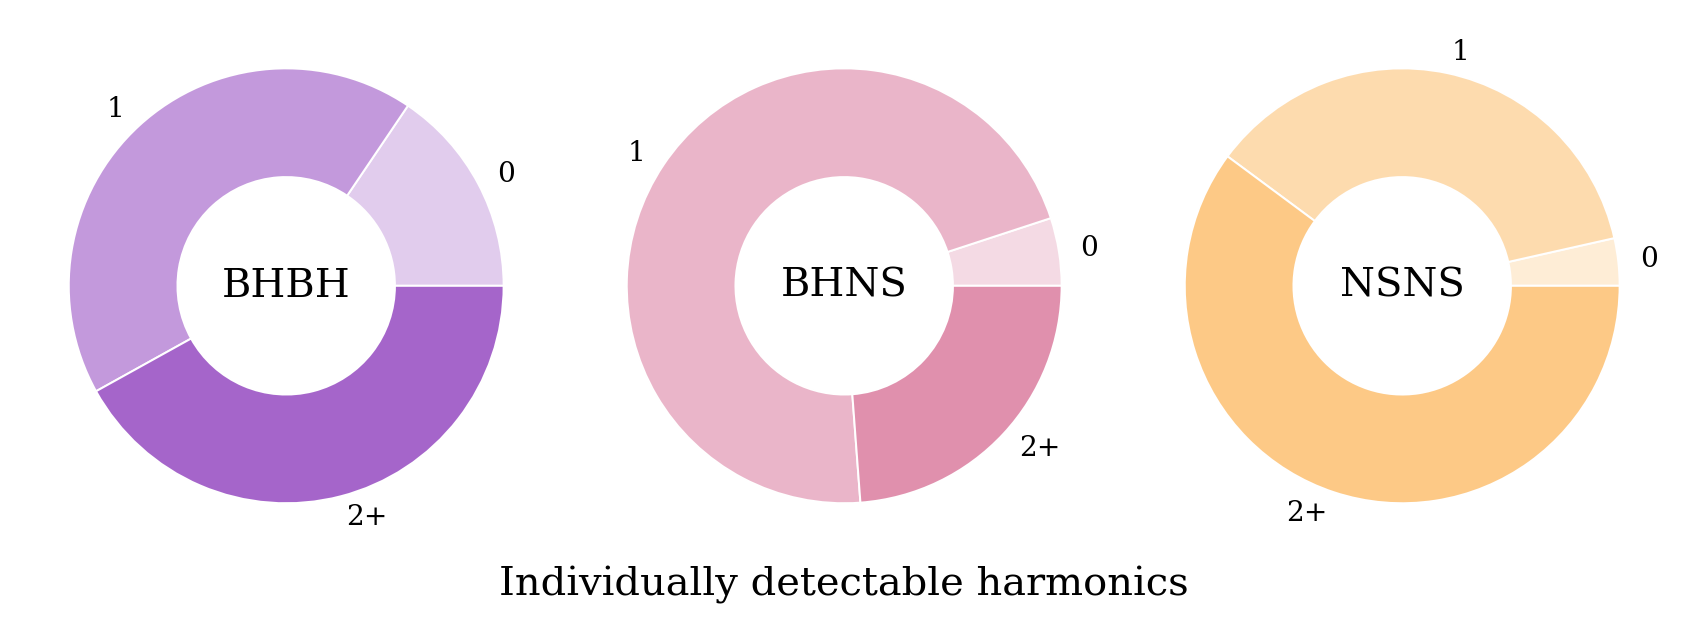

In [36]:
plot_detectable_harmonics(min_ecc=0.00, groups=[(0,1), (1, 2), (2, np.inf)], labels=["0", "1", "2+"])

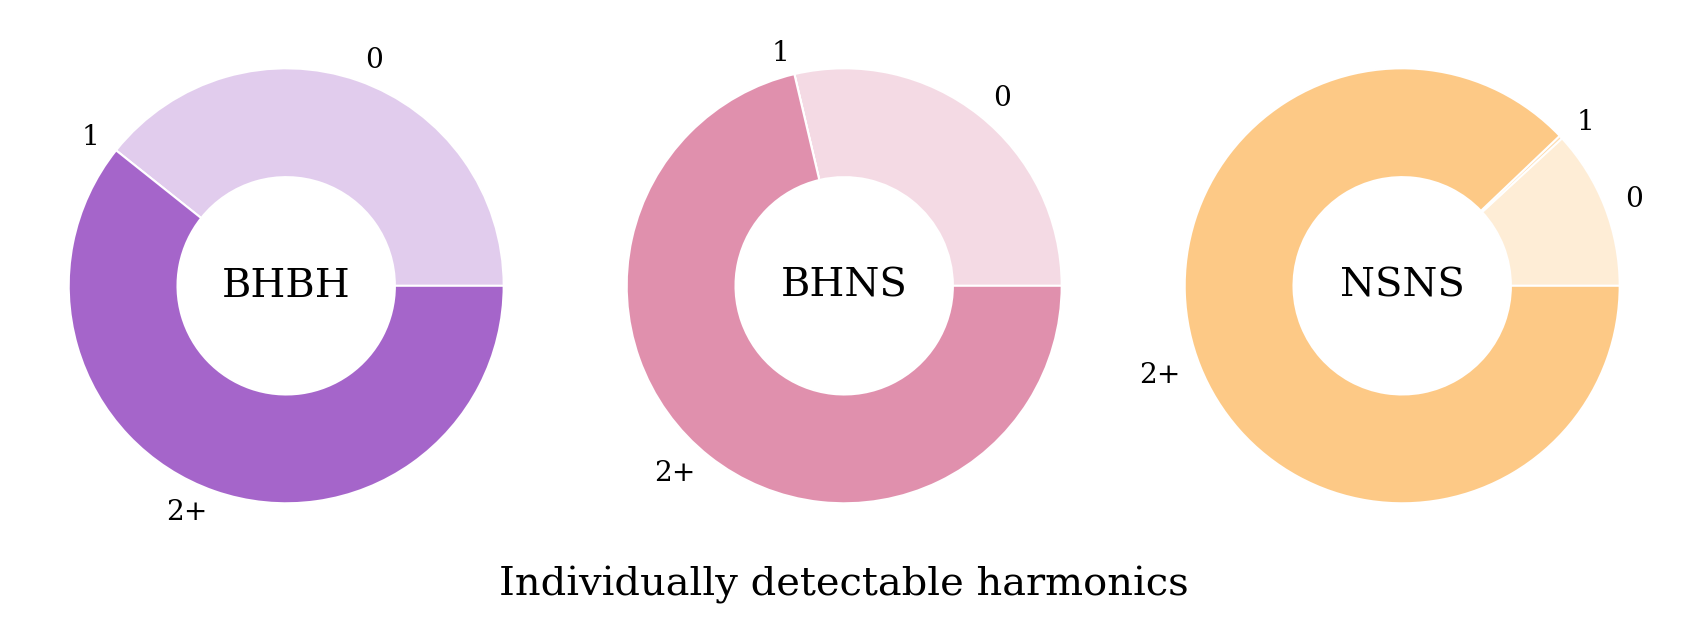

In [39]:
plot_detectable_harmonics(min_ecc=0.1, groups=[(0,1), (1, 2), (2, np.inf)], labels=["0", "1", "2+"])

## Other uncertainties

In [8]:
def sky_localisation(snr, fGW, L=2*u.AU):
    sigma_theta = 16.6 * (7 / snr) * (5e-4 * u.Hz / fGW) * (2 * u.AU / L) * u.deg
    return sigma_theta.to(u.deg)

def get_f_orb_uncertainty(snr, t_obs, f_orb):
    return (4 * np.sqrt(3) / np.pi / (snr * t_obs) / f_orb).decompose()

def get_f_orb_dot_uncertainty(snr, t_obs, f_orb_dot):
    return (6 * np.sqrt(5) / np.pi / (snr * t_obs**2) / f_orb_dot).decompose()

def get_Fprime_over_F(e):
    return e * (1256 + 1608 * e**2 + 111 * e**4) / (96 + 196 * e**2 - 255 * e**4 - 37 * e**6)

def get_m_c_uncertainty(f_orb, f_orb_dot, ecc, ecc_uncertainty, snr, t_obs):
    f_orb_uncertainty = get_f_orb_uncertainty(snr, t_obs, f_orb)
    f_orb_dot_uncertainty = get_f_orb_dot_uncertainty(snr, t_obs, f_orb_dot)
    
    return 11 / 5 * f_orb_uncertainty \
            + 3 / 5 * f_orb_dot_uncertainty \
            + 3 / 5 * get_Fprime_over_F(ecc) * ecc_uncertainty

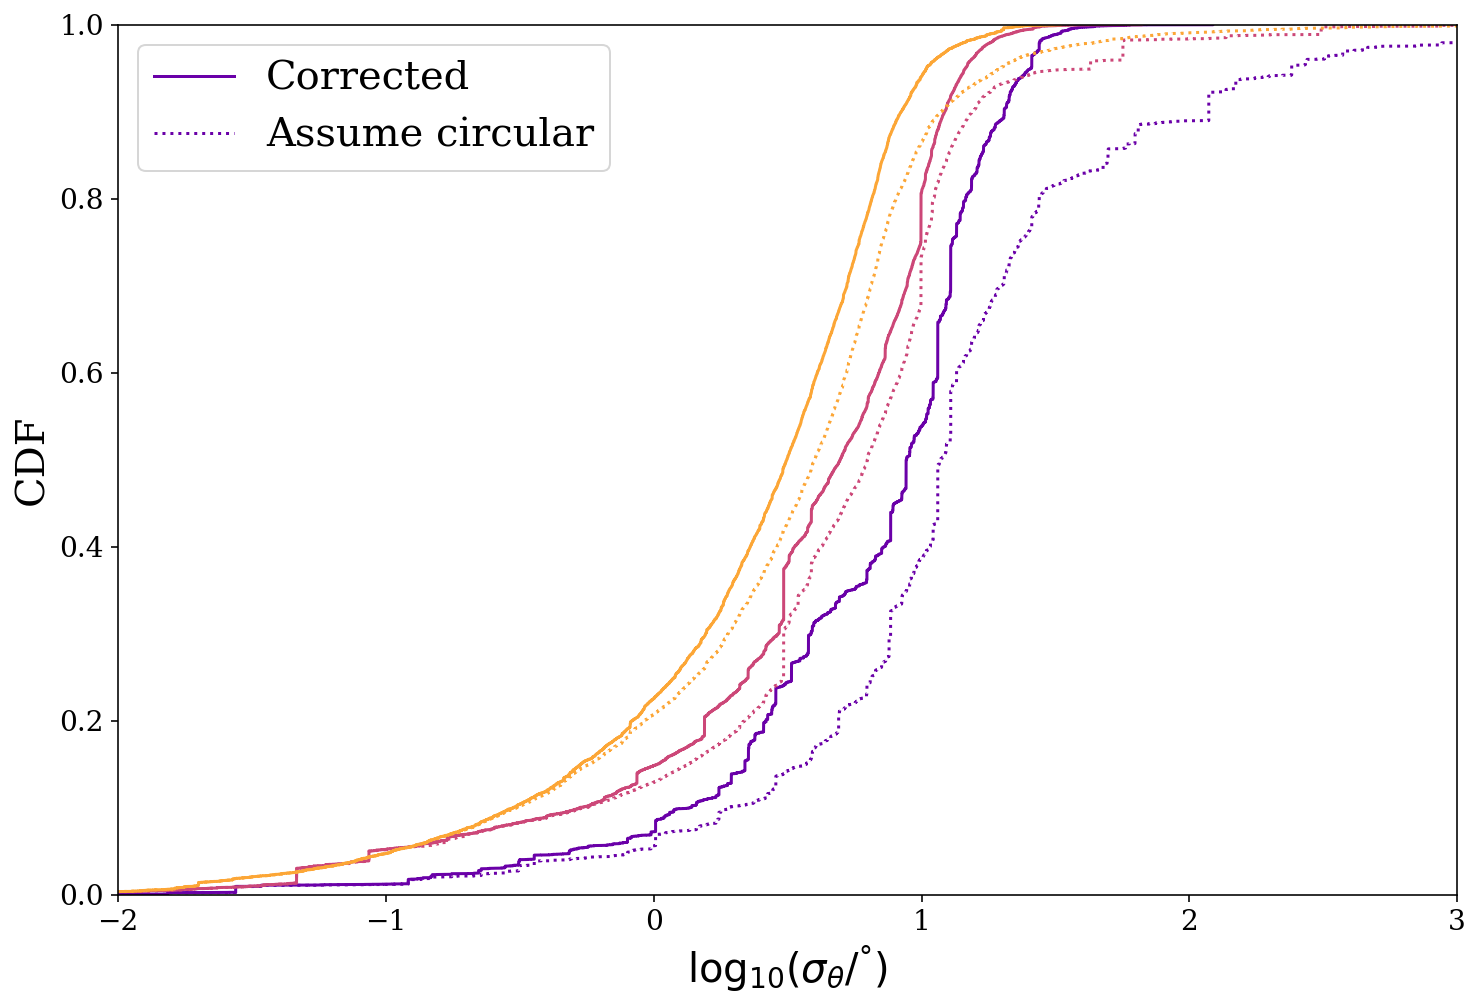

In [55]:
t_obs = 4 * u.yr
detection_threshold = 7
for i, dco_type in enumerate(dco_types):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > detection_threshold
        data = full_data[snr_mask]

        # make everything unique and adjust weights
    _, uni_index, uni_count = np.unique(data["seed"],
                                        return_index=True, return_counts=True)
    data = data[uni_index]
    data["weight"] *= uni_count

    f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                  a=data["a_LISA"] * u.AU)
    sigma_theta = sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)
    sns.ecdfplot(x=np.log10(sigma_theta.value), weights=data["weight"], color=dco_colours[dco_type], label="Corrected" if i == 0 else None)
    
    sigma_theta = sky_localisation(data["snr"], f_orb_LISA * 2).to(u.deg)
    sns.ecdfplot(x=np.log10(sigma_theta.value), weights=data["weight"], color=dco_colours[dco_type], linestyle="dotted", label="Assume circular" if i == 0 else None)
    
plt.xlim(-2, 3)
plt.xlabel(r"$\log_{10} (\sigma_{\theta} / ^\degree)$")
plt.ylabel("CDF")

plt.legend()

# Parameter distributions

In [9]:
def grid_plot(model=0, t_obs=10 * u.yr):
    fig, axes = plt.subplots(3, 3, figsize=(22, 15))

    plt.subplots_adjust(top=0.97, hspace=0.25)
    
    lw = 4

    Z_vals = np.concatenate((np.logspace(-4, np.log10(0.022), 50).round(5), [0.0244,  0.02705, 0.03]))
    inner_bins = np.array([Z_vals[i]
                           + (Z_vals[i+1] - Z_vals[i])
                           / 2 for i in range(len(Z_vals) - 1)])
    Z_bins = np.concatenate(([Z_vals[0]], inner_bins,
                             [Z_vals[-1]]))
    
    for i, dco_type in enumerate(["BHBH", "BHNS", "NSNS"]):
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            
        # make everything unique and adjust weights
        _, uni_index, uni_count = np.unique(data["seed"],
                                            return_index=True, return_counts=True)
        data = data[uni_index]
        data["weight"] *= uni_count
            
        detection_total = detections if t_obs == 4 * u.yr else detections_10yr

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)
        f_orb_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * max_harmonics[dco_type]).to(u.deg)
        
        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                          m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun).to(u.Gyr)
        
        D_Mc = get_m_c_uncertainty(f_orb_LISA, f_orb_dot, data["e_LISA"],
                                   ecc_uncertainty[dco_type], data["snr"], t_obs).decompose()
        
        resolved_in_disc = np.repeat(False, len(data))
        z_disc = 0.35 * u.kpc
        far_enough = data["dist"] > z_disc.value
        another_angle = np.arcsin(z_disc / (data["dist"][far_enough] * u.kpc)).to(u.deg)

        resolved_in_disc[far_enough] = sigma_theta[far_enough] < another_angle

#         localised = sigma_theta <= np.sqrt(0.67 / np.pi) * u.deg
        distinguished = D_Mc <= 0.1
        print(variations[model]["med"])
        print(dco_type, len(data["m_1"]))
        print("\tDetections {:1.2f}".format(detection_total[i][model].mean()))
        print("\tLocalised detections {:1.2f}".format(detection_total[i][model].mean()
                                                      * np.sum(data["weight"][resolved_in_disc]) / np.sum(data["weight"])))
        print("\tDistinguished detections {:1.2f}".format(detection_total[i][model].mean()
                                                          * np.sum(data["weight"][distinguished]) / np.sum(data["weight"])))
        print("\tLocalised AND distinguished detections {:1.2f}".format(detection_total[i][model].mean()
                                                                        * np.sum(data["weight"][np.logical_and(resolved_in_disc, distinguished)]) / np.sum(data["weight"])))

        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
            
        if dco_type in ["BHNS", "BHBH"]:
            axes[0, 0] = bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=1.4,
                                          ax=axes[0, 0], color=dco_colours[dco_type], label=dco_type)
            axes[0, 0].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 0].set_xlim(2.6, 21)

        if dco_type in ["BHNS", "NSNS"]:
            axes[0, 1] = bootstrapped_kde(mNS, mass_weights, mass_seeds, bw_adjust=0.8, log_scale=(False, True),
                                          ax=axes[0, 1], color=dco_colours[dco_type], label=dco_type)
            axes[0, 1].set_xlabel(r"Neutron Star Mass, $m_{\rm NS} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(1.26, 2.5)
        
        axes[0, 2] = bootstrapped_kde(np.log10(f_orb_LISA.value), data["weight"], data["seed"],
                                      ax=axes[0, 2], color=dco_colours[dco_type], label=dco_type)
        axes[0, 2].set_xlabel(r"Orbital Frequency, $f_{\rm orb, LISA} /, [{\rm Hz}]$")
        axes[0, 2].set_xlim(-5.1, -2.1)

        axes[1, 0] = bootstrapped_kde(data["dist"], data["weight"], data["seed"],
                                      ax=axes[1, 0], color=dco_colours[dco_type], label=dco_type)
        axes[1, 0].set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        axes[1, 0].set_xlim(0, 25)
        axes[1, 0].axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        axes[1, 0].annotate("Milky Way Centre", xy=(8.2, 0.04), color="grey", rotation=90, ha="center", va="center",
                            bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.55*fs)
        
        axes[1, 1] = bootstrapped_kde(data["tau"], data["weight"], data["seed"],
                                      ax=axes[1, 1], color=dco_colours[dco_type], label=dco_type)
        axes[1, 1].set_xlabel(r"Lookback Time, $\tau \, [\rm Gyr]$")
        axes[1, 1].set_xlim(0, 12)
        
        axes[1, 2] = bootstrapped_Z(data["Z"], weights=data["weight"], seeds=data["seed"], ax=axes[1, 2],
                                    color=dco_colours[dco_type], label=dco_type)    
        axes[1, 2].set_xscale("log")
        axes[1, 2].set_yscale("log")
        axes[1, 2].set_xlim(3e-4, 0.024)
        axes[1, 2].set_xlabel(r"Metallicity, $Z$")
        
        axes[2, 0] = bootstrapped_ecdf(D_Mc.value, weights=data["weight"], seeds=data["seed"],
                                       normalisation=detections[i, model].mean(), ax=axes[2, 0],
                                       log_scale=(True, False), color=dco_colours[dco_type], label=dco_type)
        
        axes[2, 0].set_xlabel(r"Chirp Mass Error, $\log_{10}(\Delta \mathcal{M}_c / \mathcal{M}_c)$")
        axes[2, 0].set_xlim(9e-5, 2e3)
        axes[2, 0].axvspan(1.0, axes[2, 0].get_xlim()[1], color="grey", zorder=10, alpha=0.2)

        axes[2, 1] = bootstrapped_ecdf(data["e_LISA"], weights=data["weight"], seeds=data["seed"],
                                       normalisation=detections[i, model].mean(), ax=axes[2, 1],
                                       log_scale=(True, False), color=dco_colours[dco_type], label=dco_type)
        axes[2, 1].set_xlabel(r"Eccentricity, $\log_{10}(e_{\rm LISA})$")
        axes[2, 1].set_xlim(2e-4, 1.0)
        axes[2, 1].axvspan(axes[2, 1].get_xlim()[0], 1e-2, color="grey", zorder=10, alpha=0.2)
        
        axes[2, 2] = bootstrapped_ecdf(sigma_theta.value, weights=data["weight"], seeds=data["seed"],
                                       normalisation=detections[i, model].mean(), ax=axes[2, 2],
                                       log_scale=(True, False), color=dco_colours[dco_type], label=dco_type)
        axes[2, 2].set_xlabel(r"Angular Resolution, $\log_{10}(\sigma_{\theta} / {\rm ^\circ})$")
        axes[2, 2].set_xlim(5e-3, 5e1)
        
        telescopes = [("SKA", 0.67 * u.deg**2), ("JWST NIRCam", 9.7 * u.arcmin**2), ("GOTO-Present", 40 * u.deg**2), ("GOTO-2022", 160 * u.deg**2), ("Swift", (23.6 * u.arcmin)**2)]
        
        for name, area in telescopes:
            angular_resolution = np.sqrt(area / np.pi).to(u.deg)
            axes[2, 2].axvline(angular_resolution.value, linestyle="dotted", color="grey")
            
            y = detections_10yr[:, 0].mean(axis=1).max() if t_obs == 10 * u.yr else detections[:, 0].mean(axis=1).max()
            va = "top"
            axes[2, 2].annotate(name, xy=(angular_resolution.value, y), xycoords="data", rotation=90,
                             ha="center", va=va, fontsize=0.5*fs, color="grey", bbox=dict(boxstyle="round", fc="white", ec="white"))
        
    tau, D, Z = simulate_mw(int(1e6))
    sns.kdeplot(D, ax=axes[1, 0], color="grey", bw_adjust=1.5, linestyle="dotted", cut=0)
    
    for Z in Z_vals:
        axes[1, 2].axvline(Z, zorder=-2, color="grey", linestyle="dotted", lw=0.5)
    
    handles, labels = axes[0, 2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
#         ax.set_yticks([])
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)
        
    axes[0, 0].set_ylabel("PDF")
    axes[1, 0].set_ylabel("PDF")
    axes[2, 0].set_ylabel("Cumulative detections")

    if t_obs == 4 * u.yr:
        plt.savefig("../../paper/figures/distribution_grid_4yr.pdf", format="pdf", bbox_inches="tight")
    else:
        plt.savefig("../../paper/figures/distribution_grid_10yr.pdf", format="pdf", bbox_inches="tight")

    plt.show()

fiducial
BHBH 7063
	Detections 39.58
	Localised detections 9.95
	Distinguished detections 2.45
	Localised AND distinguished detections 2.43
fiducial
BHNS 16381
	Detections 36.47
	Localised detections 11.59
	Distinguished detections 4.27
	Localised AND distinguished detections 4.26
fiducial
NSNS 15314
	Detections 8.73
	Localised detections 4.62
	Distinguished detections 1.24
	Localised AND distinguished detections 1.24


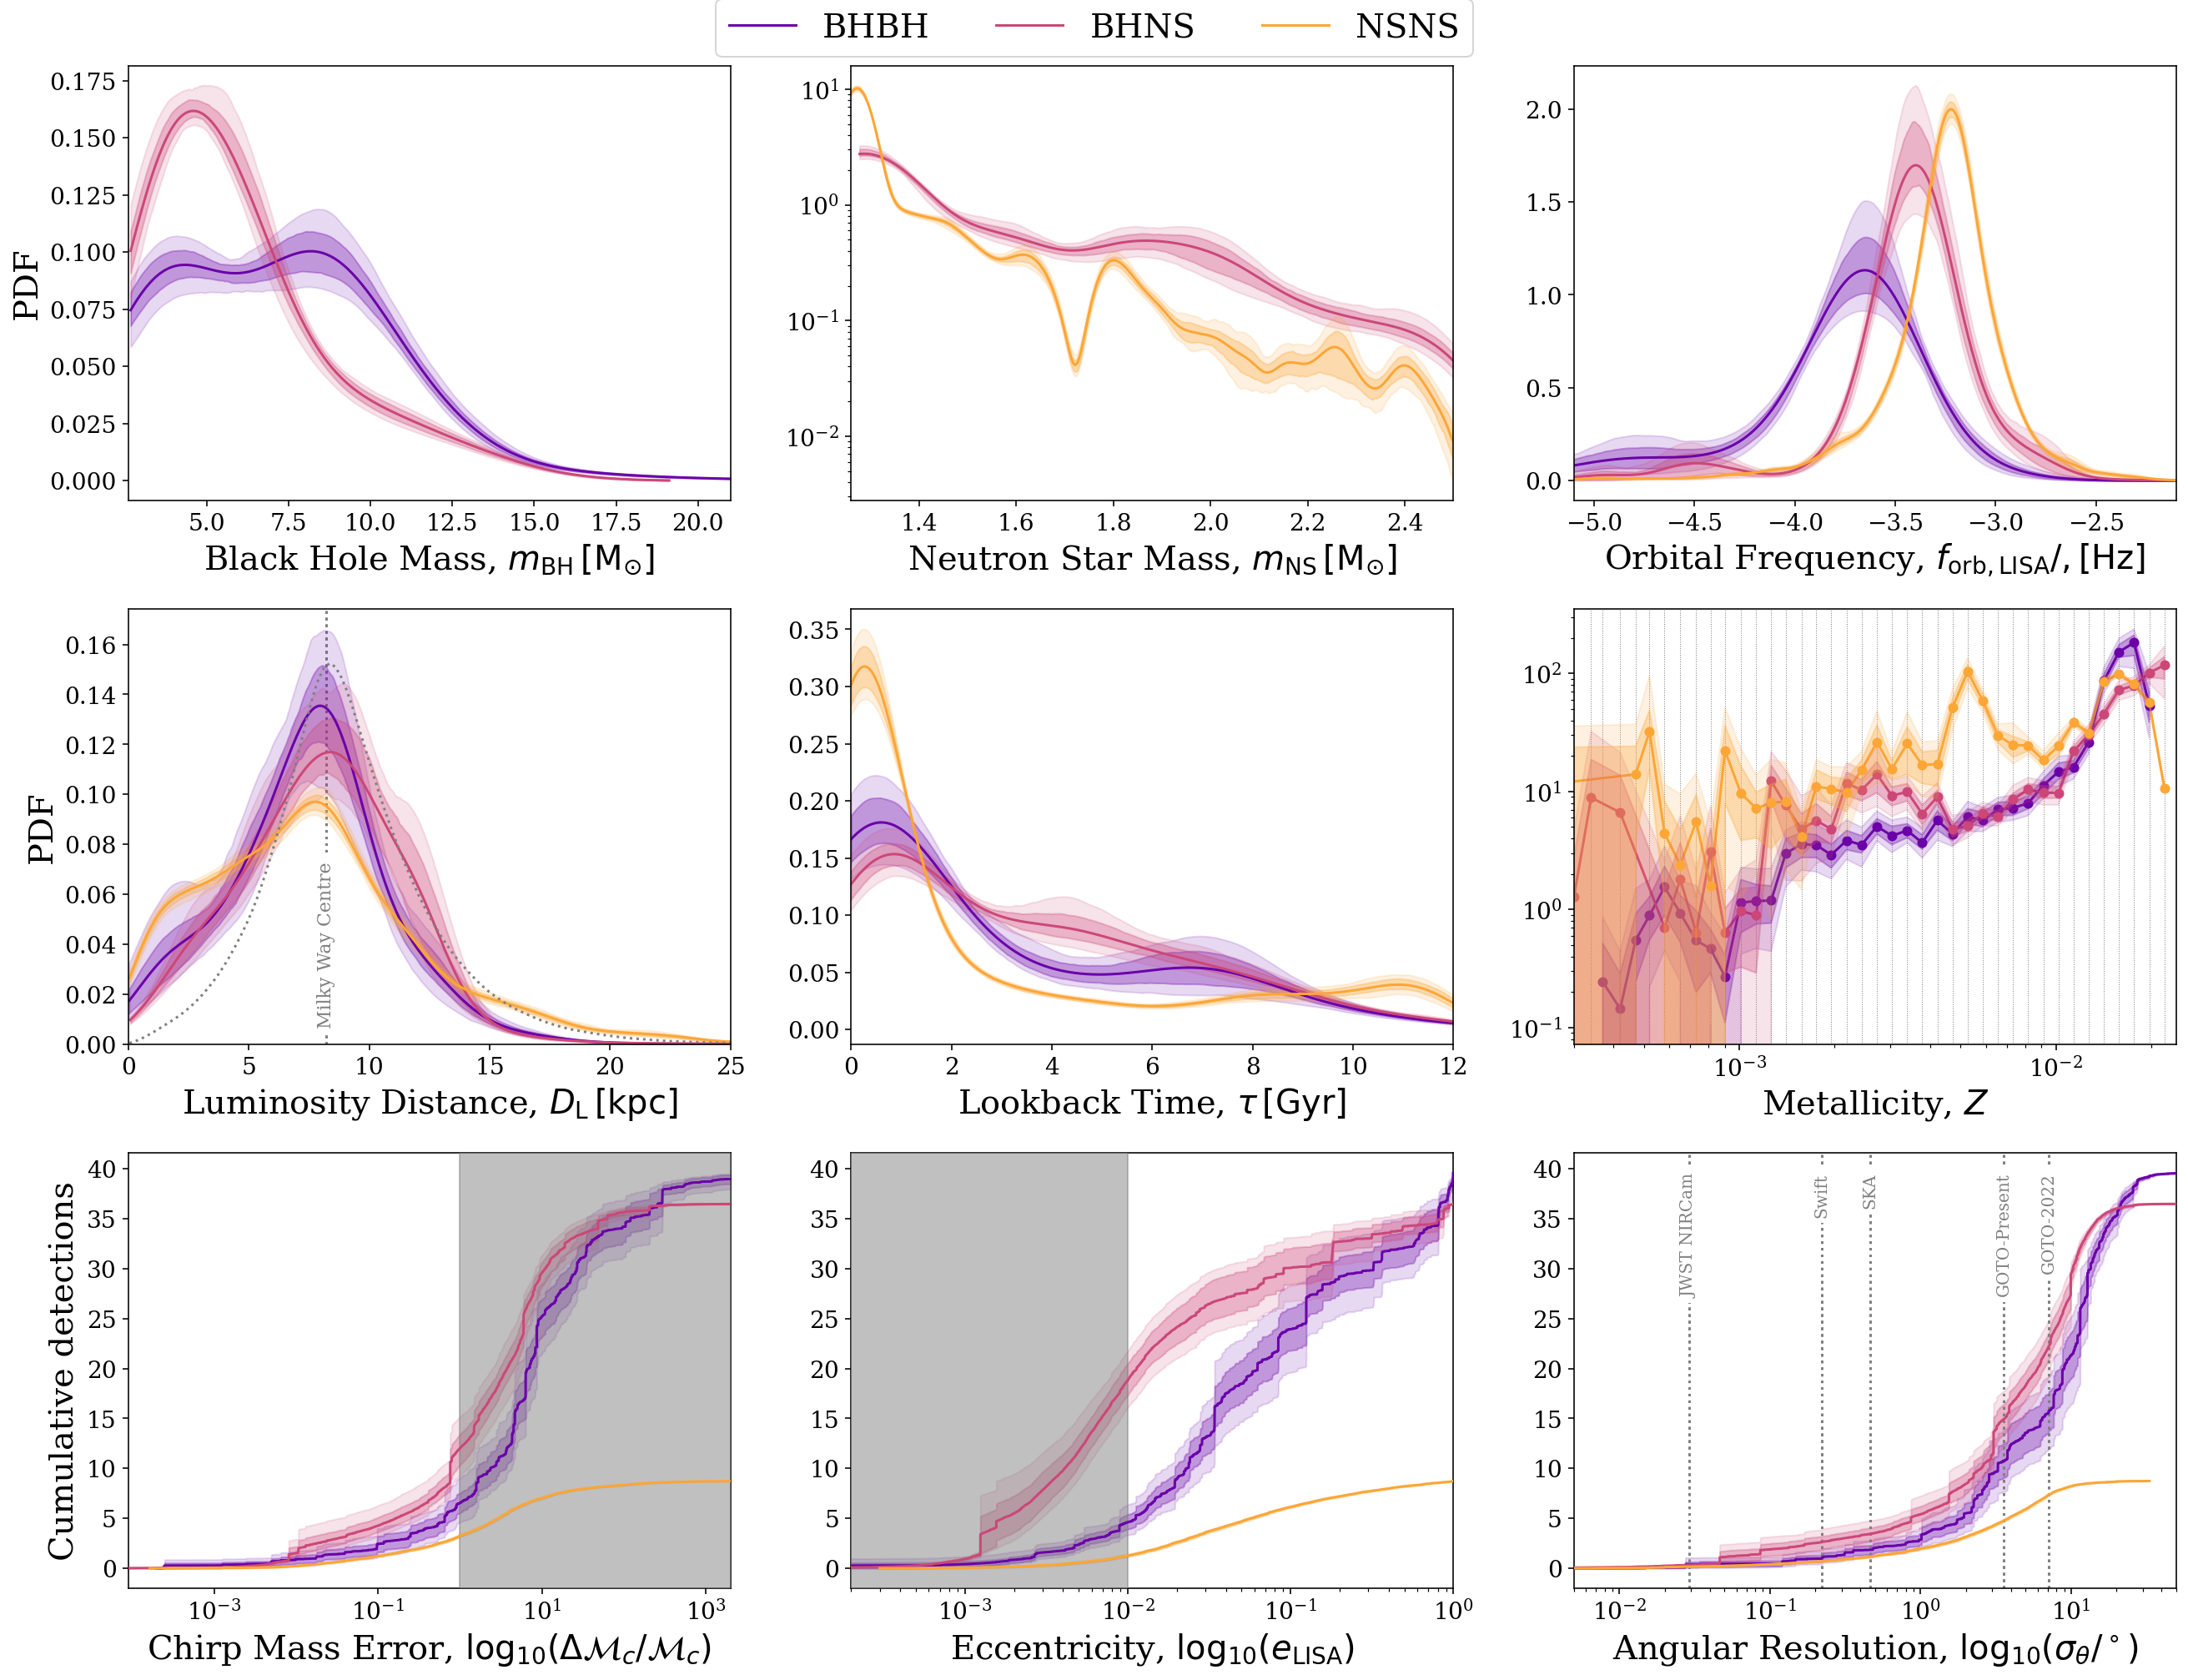

In [10]:
grid_plot(t_obs=4 * u.yr)

In [67]:
def kdeplot_something(variable, dco_type_list=["BHBH", "BHNS", "NSNS"], variation_index=0,
                      fig=None, ax=None, show=True, count_limit=np.inf, channel=None, **kwargs):
    if fig is None or ax is None:   
        fig, ax = plt.subplots(1, figsize=(10, 5))

    for dco_type in dco_type_list:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[variation_index]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] > 7

            data = full_data[snr_mask]
            
            unique_seeds, counts = np.unique(data["seed"], return_counts=True)
            count_mask = np.isin(data["seed"], unique_seeds[counts < count_limit])
            
            data = data[count_mask]
            if channel is not None:
                data = data[np.isin(data["channel"], channel)]

        sns.kdeplot(data[variable], weights=data["weight"], color=dco_colours[dco_type], cut=0, lw=4, **kwargs)

    if show:
        plt.show()
    return fig, ax

# Sensitivity curve plots

In [21]:
fid_sources = [None, None, None]
for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        
        data = full_data[snr_mask]
        
    # make everything unique and adjust weights
    _, uni_index, uni_count = np.unique(data["seed"],
                                        return_index=True, return_counts=True)
    data = data[uni_index]
    data["weight"] *= uni_count
        
    fid_sources[i] = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                dist=data["dist"] * u.kpc, ecc=data["e_LISA"],
                                                a=data["a_LISA"] * u.AU)
    fid_sources[i].weight = data["weight"]

In [22]:
for i in range(len(dco_types)):
    fid_sources[i].get_snr(verbose=True)

Calculating SNR for 7063 sources
	7061 sources are stationary
		6011 sources are stationary and circular
		1050 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular
Calculating SNR for 16381 sources
	16379 sources are stationary
		15766 sources are stationary and circular
		613 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular
Calculating SNR for 15314 sources
	15312 sources are stationary
		8929 sources are stationary and circular
		6383 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular


In [28]:
def plot_sc_with_dist_lines(frequency_range, fig, ax, mc_mean, mc_min, line_scale=1, line_rot=10, loc=-50):
    legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=frequency_range, fig=fig, ax=ax)
    
    times = np.logspace(0, -8, 9) * u.Gyr
    athings = np.power(4 * legwork.utils.beta(mc_min * 2**(1/5), mc_min * 2**(1/5)) * times, 1/4)
    freqs = legwork.utils.get_f_orb_from_a(a=athings, m_1=mc_min * 2**(1/5), m_2=mc_min * 2**(1/5))
    hide_height = np.sqrt(legwork.psd.lisa_psd(freqs))
    
    for i in range(len(times)):
        ax.plot([freqs[i].value, freqs[i].value], [hide_height[i].value, 1e-13],
                color="grey", lw=line_scale, zorder=0, linestyle="dotted")
        ax.annotate(r"$10^{{{0:1.0f}}}$ yr".format(np.log10(times[i].to(u.yr).value)), xy=(freqs[i].value, 7.5e-14),
                    va="top", ha="center", rotation=90, fontsize=10 * line_scale, color="grey",
                    bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    line_length = 1000
    lines_f_range = np.logspace(-6.5, -1.4, line_length) * u.Hz
    for dist in [0.1, 0.5, 8, 30]:
        dist_line_signal = np.sqrt(4 * u.yr).to(u.Hz**(-1/2))\
            * legwork.strain.h_0_n(m_c=np.repeat(mc_mean, line_length),
                                   dist=np.repeat(dist, line_length) * u.kpc, 
                                   f_orb=lines_f_range,
                                   n=2,
                                   ecc=np.zeros(line_length))[:, 0, 0]
        mask = dist_line_signal > np.sqrt(legwork.psd.lisa_psd(lines_f_range * 2))
        ax.plot(lines_f_range[mask] * 2, dist_line_signal[mask], color="grey", linestyle="dotted", zorder=0, lw=line_scale)
        ax.annotate("{} kpc".format(dist), xy=(lines_f_range[mask][-20].value, dist_line_signal[mask][-20].value * (0.45 + line_scale / 20)), xycoords="data", color="grey", rotation=line_rot * 1.2, 
                         ha="right", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    for e_dist_line in [0.97]:
        nmax = 220 if e_dist_line == 0.9 else 1000
        e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                          ecc=np.repeat(e_dist_line, line_length),
                                          f_orb=lines_f_range,
                                          m_1=np.repeat(mc_min * 2**(1/5), line_length),
                                          m_2=np.repeat(mc_min * 2**(1/5), line_length))
        e_sources.get_snr()
        dominant_freq = lines_f_range * e_sources.max_snr_harmonic
        e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
        check = np.argmin(np.diff(dominant_freq))
        mask = e_sources.snr[:check] > 1
        ax.plot(dominant_freq[:check][mask], e_dist_line_signal[:check][mask], lw=line_scale, zorder=0, color="grey", linestyle="dotted")

    ax.annotate("{} kpc, e={}".format(dist, e_dist_line), xy=(dominant_freq[:check][mask][loc].value, e_dist_line_signal[:check][mask][loc].value), xycoords="data", color="grey",
                     rotation=line_rot, ha="center", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    ax.annotate(r"$\langle \mathcal{{M}}_c \rangle = {{{0:1.2f}}} \, M_{{\odot}}$".format(mc_mean.value), xy=(1e-2, 3e-20), ha="center", va="center", 
                fontsize=12 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    return fig, ax

In [35]:
fid_sources[2].get_merger_time().min().to(u.yr)

<Quantity 90.47855214 yr>

full done
BHBH done
BHNS done
NSNS done


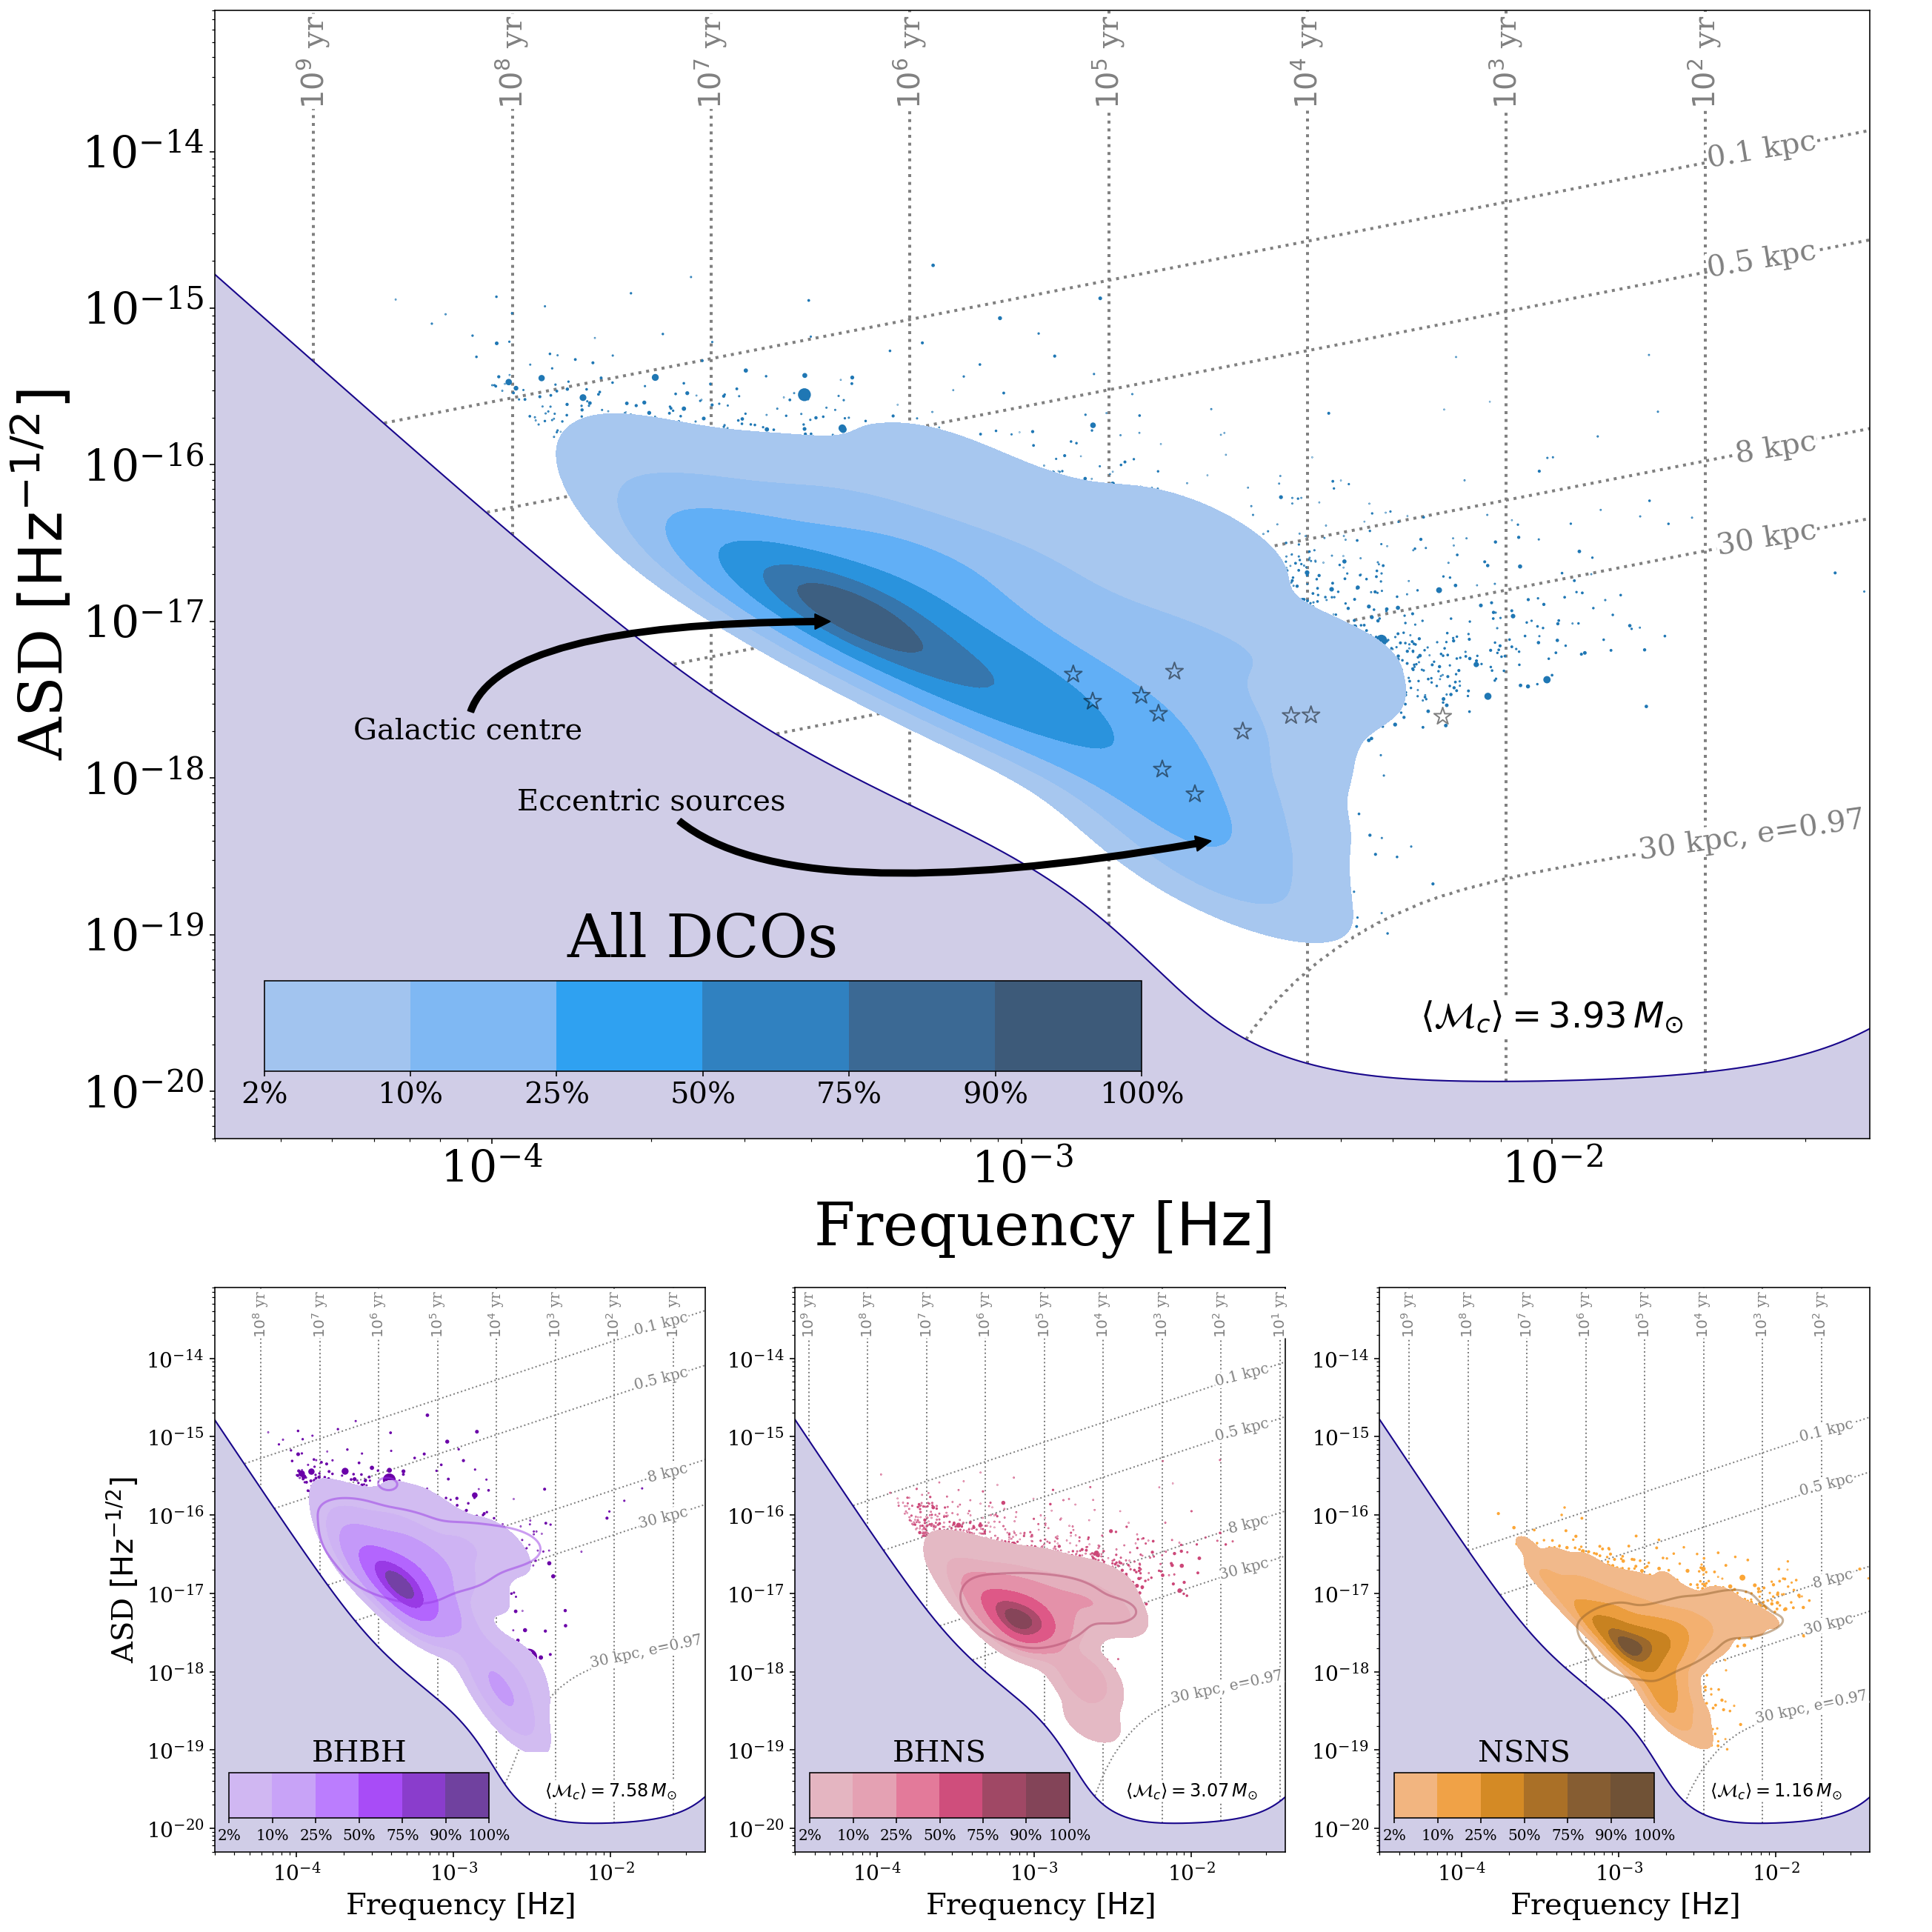

In [113]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig = plt.figure(figsize=(18, 18), constrained_layout=True)

gs = GridSpec(2, 3, figure=fig, height_ratios=(2, 1))
all_ax = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[1, i]) for i in range(3)]
levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

all_mc_mean = np.mean([fid_sources[i].m_c.mean().value for i in range(len(fid_sources))]) * u.Msun
all_mc_min = np.min([fid_sources[i].m_c.min().value for i in range(len(fid_sources))]) * u.Msun
fig, all_ax = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=all_ax,
                                      mc_mean=all_mc_mean,
                                      mc_min=all_mc_min,
                                      line_scale=2, line_rot=8, loc=-10)

all_f_dom = np.concatenate([fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic for i in range(len(fid_sources))])
all_snr = np.concatenate([fid_sources[i].snr for i in range(len(fid_sources))])
all_weight = np.concatenate([fid_sources[i].weight for i in range(len(fid_sources))])
all_ecc = np.concatenate([fid_sources[i].ecc for i in range(len(fid_sources))])

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", s=all_weight * 25) #fid_sources[i].ecc

all_ax.annotate("Galactic centre",
                xy=(4.4e-4, 1e-17), xycoords='data',
                xytext=(9e-5, 2e-18), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=90,angleB=0"),
                fontsize=fs, ha="center", va="center")

all_ax.annotate("Eccentric sources",
                xy=(2.3e-3, 4e-19), xycoords='data',
                xytext=(2e-4, 7e-19), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=120,angleB=10", relpos=(0.5, 1.0)),
                fontsize=fs, ha="center", va="center")

f_GWs = [vb["f_GW"].to(u.Hz).value for vb in verification_binaries]
ASDs = [(legwork.psd.lisa_psd(vb["f_GW"])**(0.5) * vb["snr"]).to(u.Hz**(-1/2)).value for vb in verification_binaries]
all_ax.scatter(f_GWs, ASDs, s=150, facecolor="none", edgecolor="black", marker="*", alpha=0.5,
               label="Verification binaries", zorder=10)

# the lazy man's guide to colorbars: just plot hidden points
cmap = cmap_from_colour("tab:blue")
scatter = all_ax.scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
inset_all_ax = all_ax.inset_axes([0.03, 0.06, 0.53, 0.08])
cbar = fig.colorbar(scatter, ax=all_ax, cax=inset_all_ax, boundaries=levels, orientation="horizontal")
cbar.set_ticklabels(["2%", "10%", "25%", "50%", "75%", "90%", "100%"])
cbar.ax.tick_params(labelsize=fs)

all_ax.annotate("All DCOs", xy=(0.295, 0.15), xycoords="axes fraction", fontsize=2 * fs, color="black", ha="center", va="bottom")

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", weights=all_weight,
                                                  disttype="kde", fill=True, levels=levels)

print("full done")

for i, dco_type in enumerate(dco_types):
    fig, axes[i] = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=axes[i],
                                           mc_mean=fid_sources[i].m_c.mean(),
                                           mc_min=fid_sources[i].m_c.min(), line_rot=12, loc=-75)
    
    # the lazy man's guide to colorbars: just plot hidden points
    cmap = cmap_from_colour(dco_colours[dco_types[i]])
    scatter = axes[i].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = axes[i].inset_axes([0.03, 0.06, 0.53, 0.08])
    cbar = fig.colorbar(scatter, ax=axes[i], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(["2%", "10%", "25%", "50%", "75%", "90%", "100%"])
    cbar.ax.tick_params(labelsize=10)
    
    f_dom = fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], s=fid_sources[i].weight * 25)
    
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], weights=fid_sources[i].weight,
                                                      disttype="kde", fill=True, levels=levels)
    
    mask = fid_sources[i].ecc < 0.01
    color = list(cmap(0.75))
    color[-1] = 0.5
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom[mask], snr=fid_sources[i].snr[mask],
                                                      fig=fig, ax=axes[i], show=False, color=tuple(color),
                                                      weights=fid_sources[i].weight[mask], disttype="kde",
                                                      fill=False, levels=[0.1],
                                                      bw_adjust=0.8 if i == 0 else 1.0 if i == 1 else 0.9)

    axes[i].annotate(dco_types[i], xy=(0.295, 0.15), xycoords="axes fraction",
                     fontsize=fs, color="black", ha="center", va="bottom")
    
    print(dco_types[i], "done")

ylims = (5e-21, 8e-14)
    
for ax in [all_ax] + axes:
    if ax in axes[1:]:
        ax.set_ylabel("")
    ax.set_ylim(ylims)
    
all_ax.tick_params(labelsize=1.5 * fs)
all_ax.xaxis.label.set_fontsize(2 * fs)
all_ax.yaxis.label.set_fontsize(2 * fs)

# plt.savefig("../../paper/figures/dcos_on_sc.png", dpi=300, bbox_inches="tight")
# plt.savefig("../../paper/figures/dcos_on_sc_high_res.png", dpi=600, bbox_inches="tight")

# plt.savefig("../../paper/figures/dcos_on_sc.png_alt", dpi=300, bbox_inches="tight")
# plt.savefig("../../paper/figures/dcos_on_sc_high_res_alt.png", dpi=600, bbox_inches="tight")

plt.show()

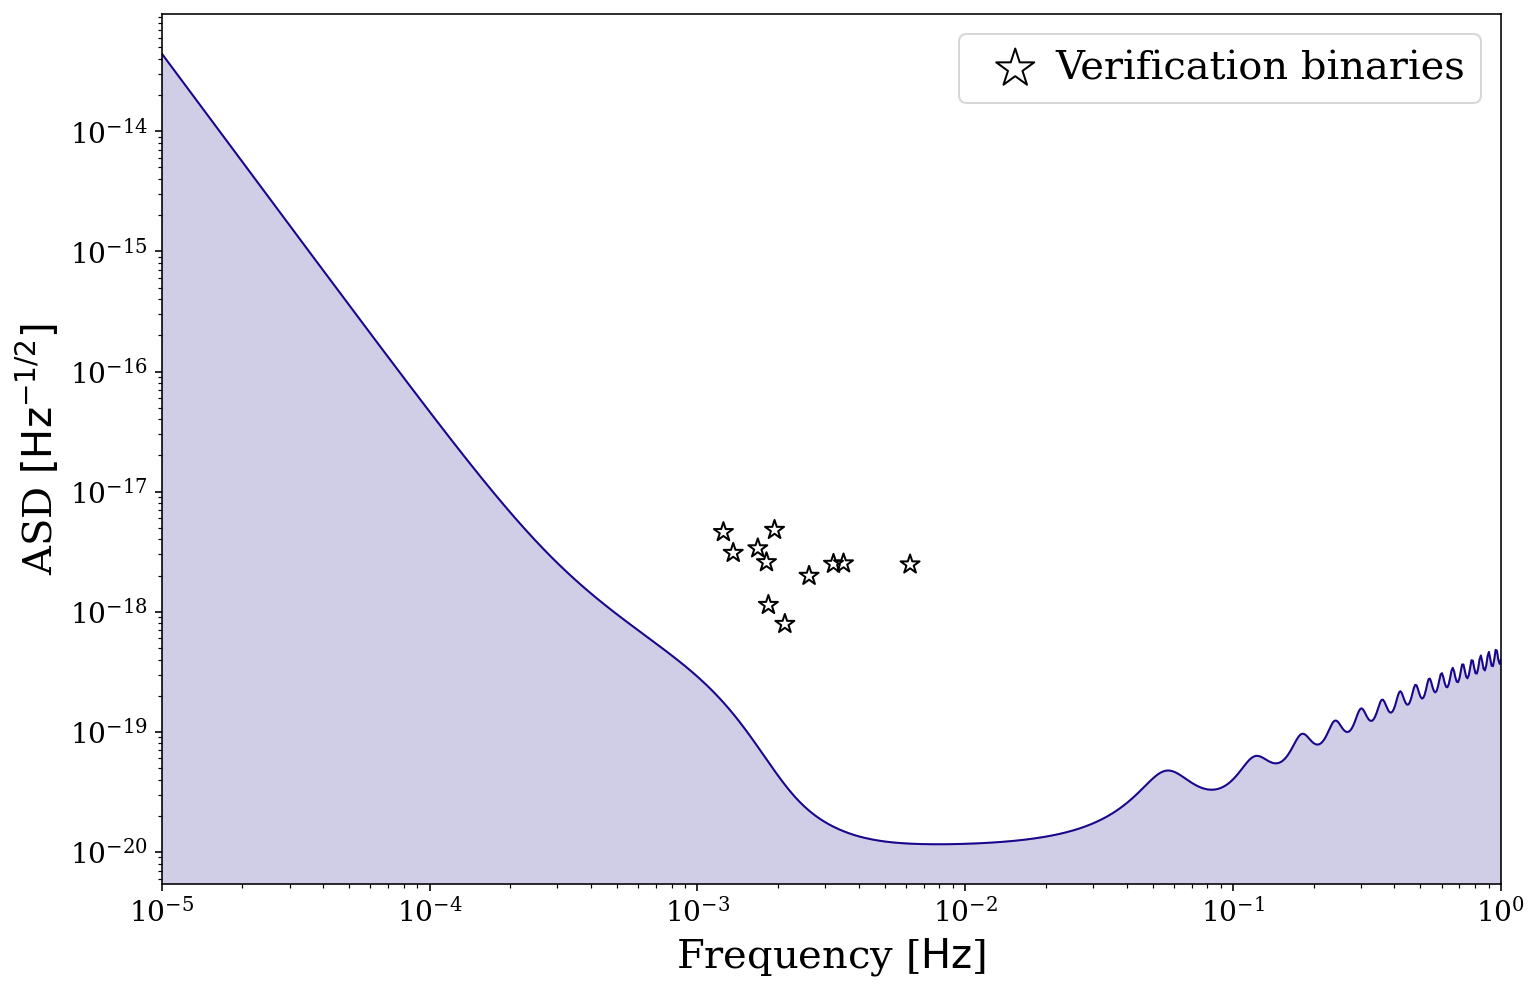

In [105]:
fig, ax = legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=np.logspace(-5, 0, 1000) * u.Hz)

f_GWs = [vb["f_GW"].to(u.Hz).value for vb in verification_binaries]
ASDs = [(legwork.psd.lisa_psd(vb["f_GW"])**(0.5) * vb["snr"]).to(u.Hz**(-1/2)).value for vb in verification_binaries]
ax.scatter(f_GWs, ASDs, s=100, facecolor="none", edgecolor="black", marker="*", label="Verification binaries")
    
ax.legend(handletextpad=0.0, markerscale=2.0)

plt.show()

# Tau-Z stuff (TODO)

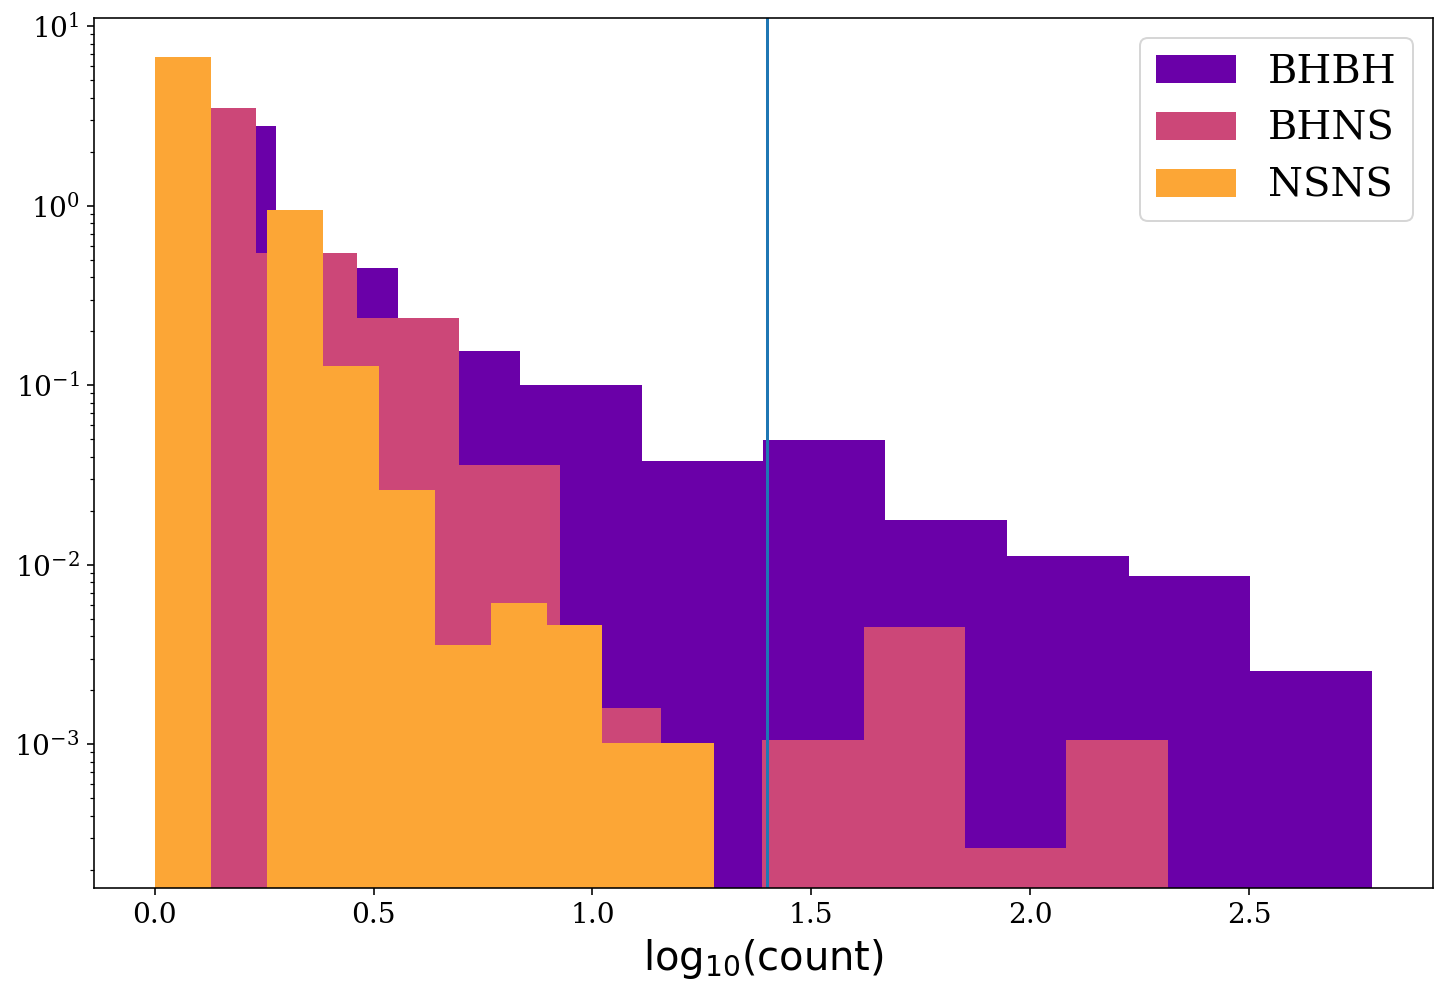

In [214]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    uniques, counts = np.unique(data["seed"], return_counts=True)
    
    plt.hist(np.log10(counts), density=True, log=True, color=dco_colours[dco_type], label=dco_type)

plt.legend()

plt.xlabel(r"$\log_{10} (\rm count)$")

plt.axvline(np.log10(25))

plt.show()

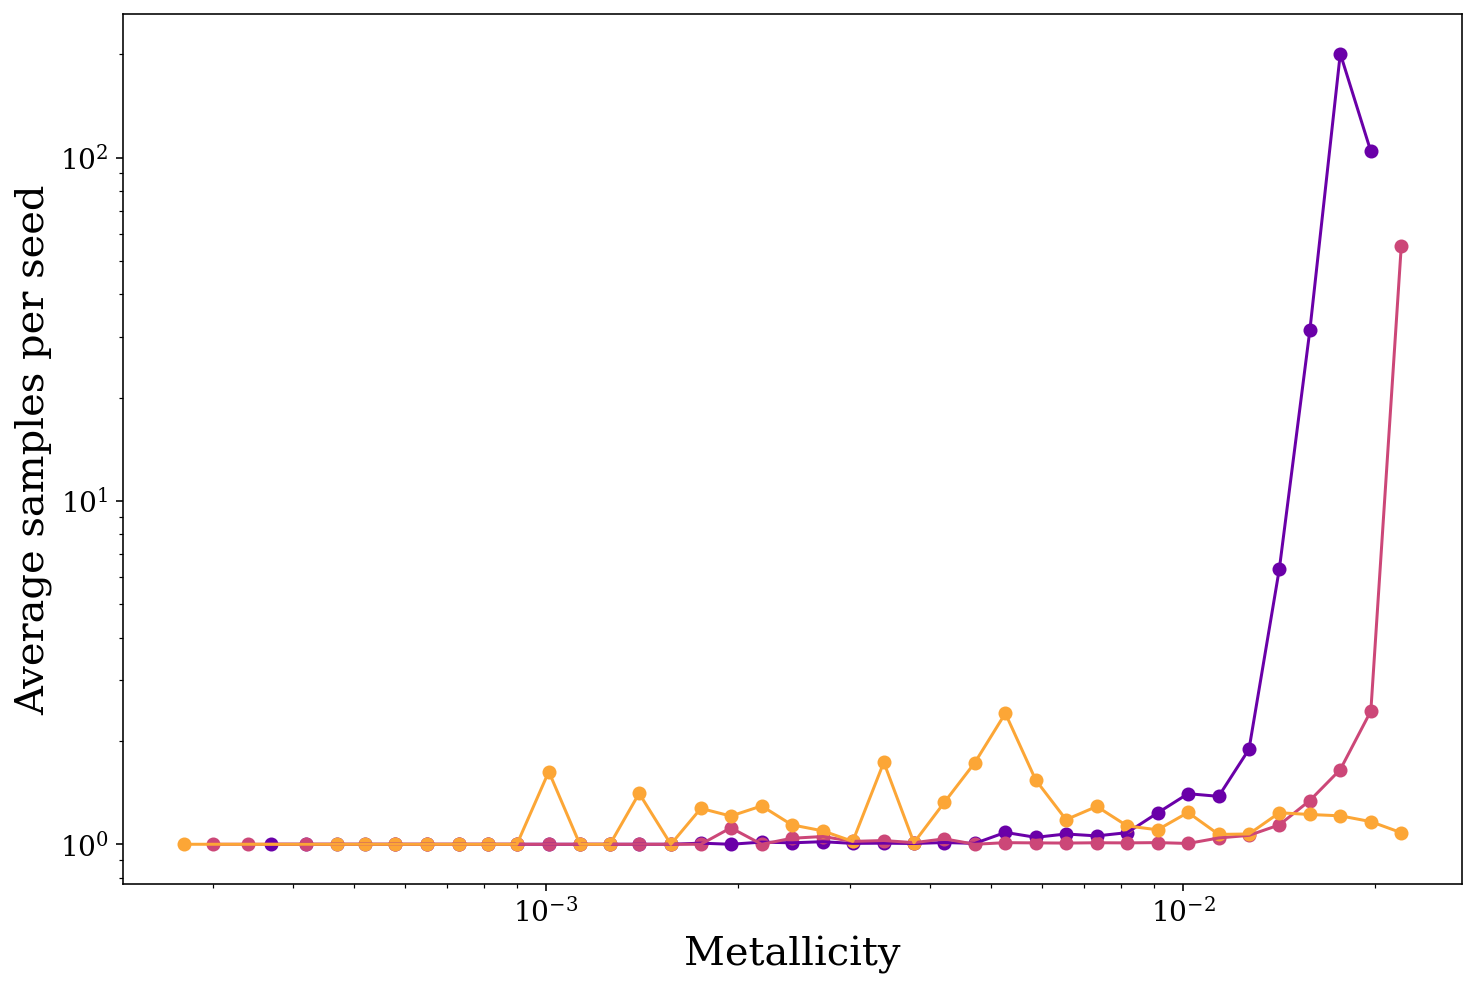

In [291]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    uniques, ind, counts = np.unique(data["seed"], return_index=True, return_counts=True)
    
#     plt.scatter(data["Z"][ind], counts, color=dco_colours[dco_type])
    
    unique_Z = np.unique(data["Z"])
    means = np.zeros(len(unique_Z))
    for i, Z in enumerate(unique_Z):
        mask = data["Z"][ind] == Z
        means[i] = np.average(counts[mask], weights=data["weight"][ind][mask])
#         plt.scatter(Z, counts[mask].min(), color=dco_colours[dco_type], marker="^")
#         plt.scatter(Z, counts[mask].max(), color=dco_colours[dco_type], marker="v")
    plt.scatter(unique_Z, means, color=dco_colours[dco_type])
    plt.plot(unique_Z, means, color=dco_colours[dco_type])
    
#     plt.hist(np.log10(counts), density=True, log=True, color=dco_colours[dco_type], label=dco_type)

# plt.legend()

# plt.xlabel(r"$\log_{10} (\rm count)$")

# plt.axvline(np.log10(25))

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Metallicity")
plt.ylabel("Average samples per seed")

plt.show()

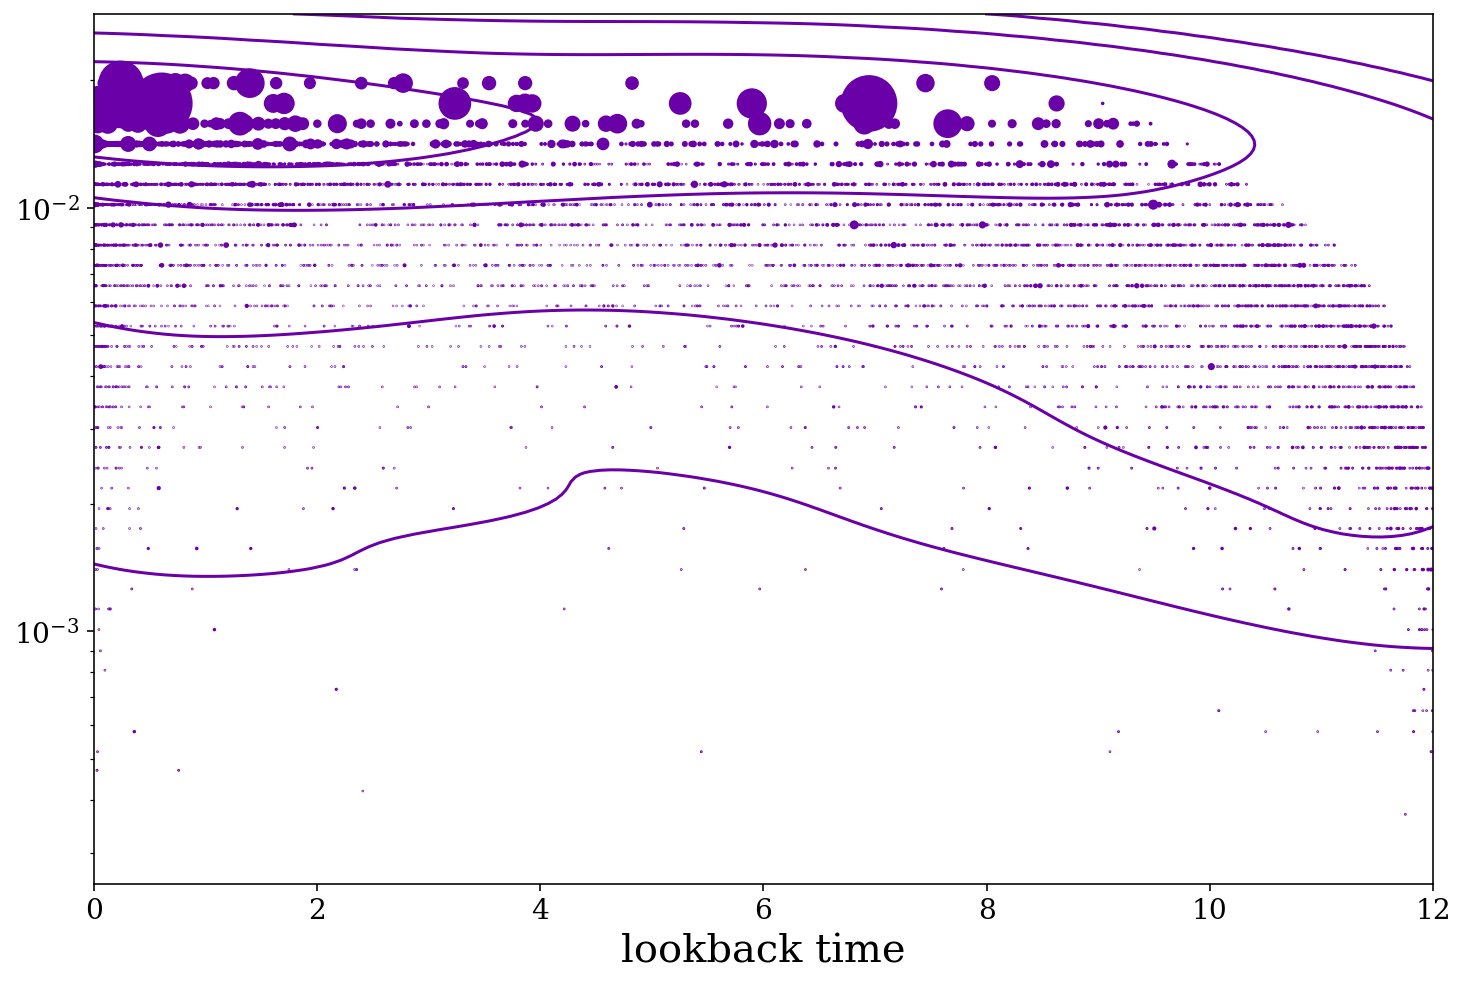

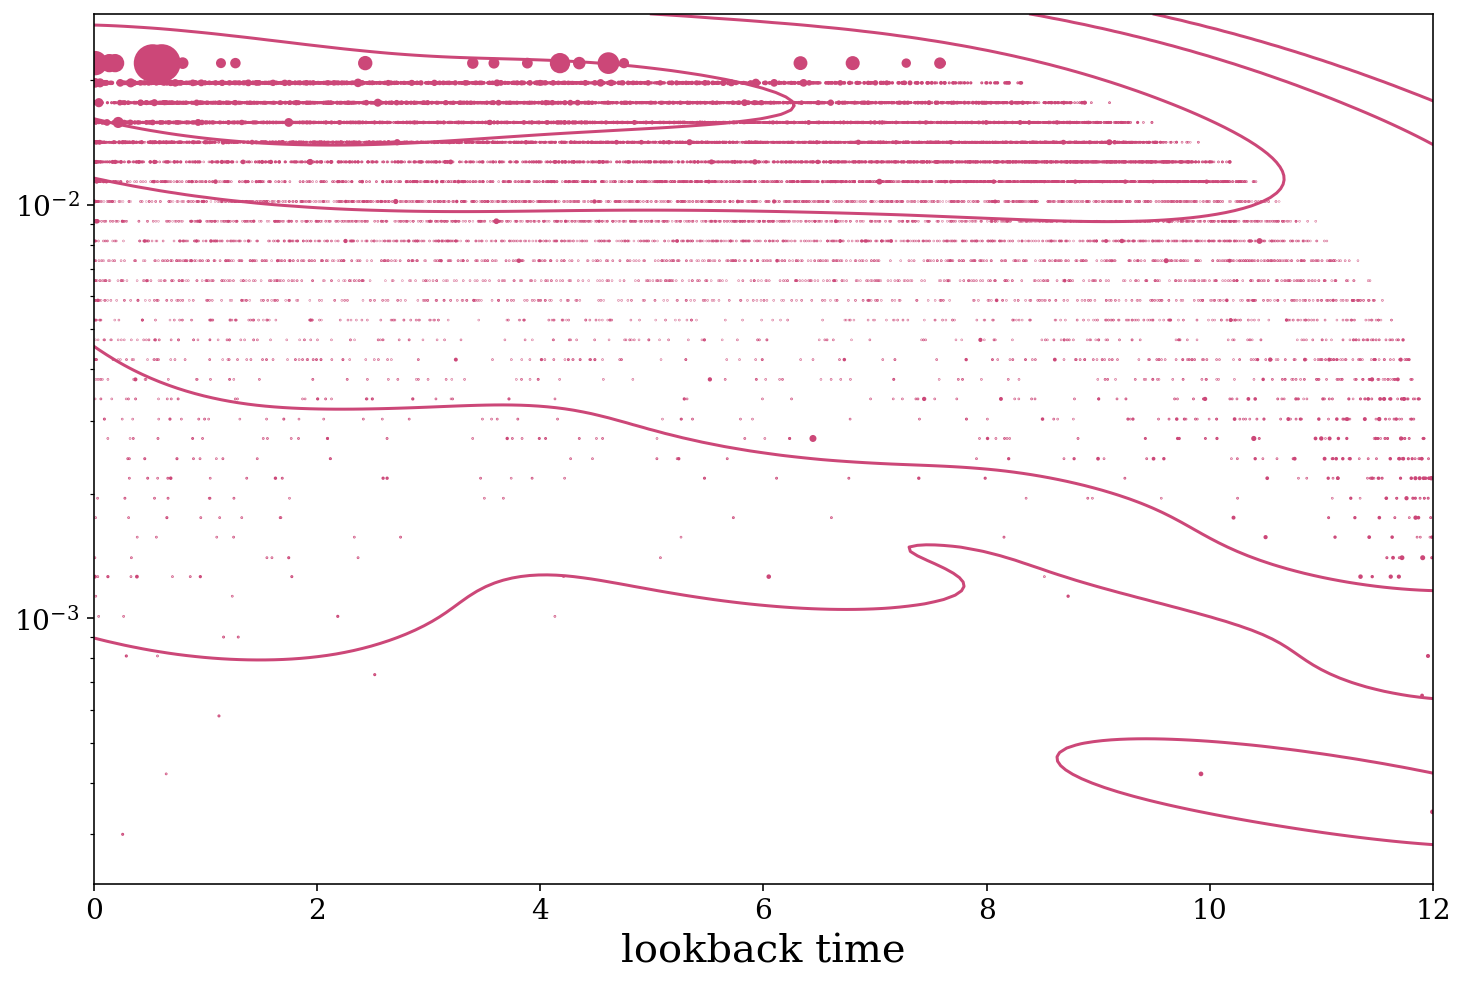

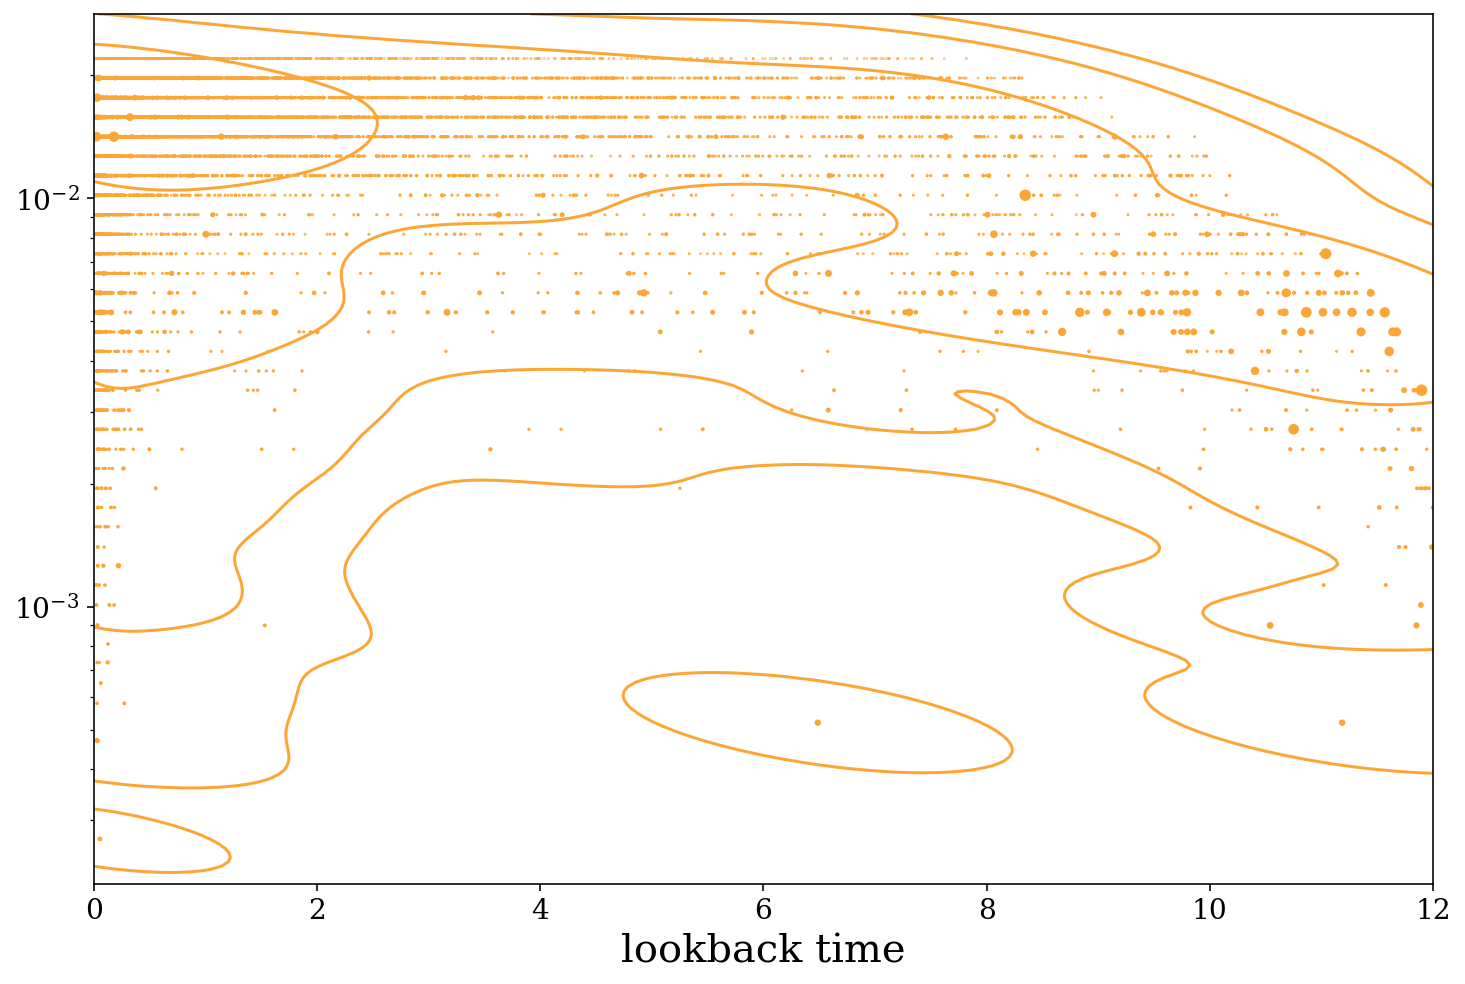

In [259]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    # make everything unique and adjust weights
    _, uni_index, uni_count = np.unique(data["seed"],
                                        return_index=True, return_counts=True)
    data = data[uni_index]
    data["weight"] *= uni_count
        
    plt.scatter(data["tau"], data["Z"], s=data["weight"] * 10, color=dco_colours[dco_type])
    sns.kdeplot(x=data["tau"], y=data["Z"], weights=data["weight"], color=dco_colours[dco_type],
                log_scale=(False, True), levels=[0.001, 0.01, 0.1, 0.5])

    plt.xlabel("lookback time")
    plt.xlim(0, 12)
#     plt.yscale("log")
    plt.show()